Load libraries and read data.

In [1]:
source("~/smartas/pipeline/scripts/variablesAndFunctions.r")
library(ggrepel)

# read switches
switches <- read.delim(paste0(project,"switches/v42/tables/candidateList_splitByTumor_models_notNoise.txt"),row.names=NULL)

# read candidate info
candidates <- read.delim(paste0(project,"switches/v42/driverEvidence.tsv"),row.names=NULL)
candidates <- merge(candidates,switches)
candidates <- candidates[as.logical(rowSums(candidates[,c("Recurrence","Affects_mutated_feature","Mutual_exclusion","Coocurrence","PPI")])),]

## filter-out non-functional switches
candidates <- subset(candidates, IsFunctional==1)

# read ME with top drivers
me <- list()
for (i in 1:10){
  this.me <- read.delim(paste0(project,"mutations/v59/pannegative_mutual_exclusion.top_",i,"_drivers.txt"),row.names=NULL)
  this.me$NumDrivers <- i
  this.me$Total <- this.me$M + this.me$MS + this.me$S + this.me$N
  
  this.me$M.p <- this.me$M/this.me$Total
  this.me$MS.p <- this.me$MS/this.me$Total
  this.me$S.p <- this.me$S/this.me$Total
  this.me$N.p <- this.me$N/this.me$Total
  
  me[[i]] <- this.me
}
me <- do.call("rbind",me)
me$SwitchSamples <- me$S + me$MS

# drivers mutations
mutatedDrivers <- read.delim(paste0(project,"mutations/v59/driver_mutation_number.txt"),row.names=NULL)
mutatedDrivers$PatientNumber <- unlist(lapply(strsplit(as.character(mutatedDrivers$Samples),","),length))
mutatedDrivers$Rank <- as.numeric(do.call("c",by(-mutatedDrivers$PatientNumber,mutatedDrivers$Tumor,rank)))

# read mutual exclusion with specific drivers
me.specificDrivers <- read.delim(paste0(project,"mutations/v59/mutual_exclusion_top_drivers.txt"),row.names=NULL)

total <- me.specificDrivers$M + me.specificDrivers$MS + me.specificDrivers$S + me.specificDrivers$N

me.specificDrivers$M.p <- me.specificDrivers$M/total
me.specificDrivers$MS.p <- me.specificDrivers$MS/total
me.specificDrivers$S.p <- me.specificDrivers$S/total
me.specificDrivers$N.p <- me.specificDrivers$N/total

## read specific drivers
drivers.file <- paste0("~/smartas/data/ucsc/intogen_cancer_drivers-2014.12b/Mutational_drivers_per_tumor_type.tsv")
drivers <- read.delim(drivers.file,skip=5,row.names=NULL,header=T)

# PoTuS identification

## Pan-negative

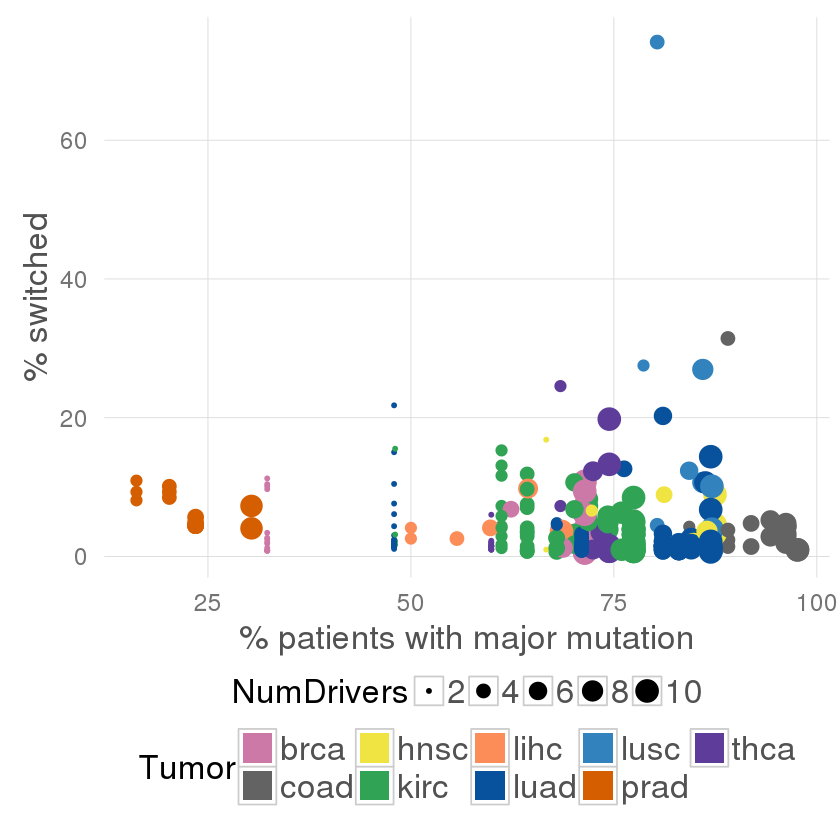

In [2]:
potus.pn <- merge(candidates,subset(me,p.me<0.05))
df <- by(potus.pn, 
         paste0(potus.pn$GeneId,potus.pn$Tumor), 
         function(X) X[which.max(X$NumDrivers),])
df <- do.call("rbind",df)

ggplot(df,aes(x=(M.p+MS.p)*100,y=(S.p+MS.p)*100,color=Tumor)) + 
  geom_point(aes(size=NumDrivers)) + 
  #geom_text_repel(aes(label=Symbol)) +
  smartas_theme() +
  scale_color_manual(values=colorPalette) +
  labs(x="% patients with major mutation", y="% switched") +
  theme(legend.position="bottom") +
  guides(col = guide_legend(override.aes = list(shape = 15, size = 8)))

df <- as.data.frame(table(df$Tumor))
colnames(df) <- c("Tumor","Pannegative")
df$pnPercentage <- df[,2]/as.numeric(table(switches$Tumor))*100

## Mutational drivers

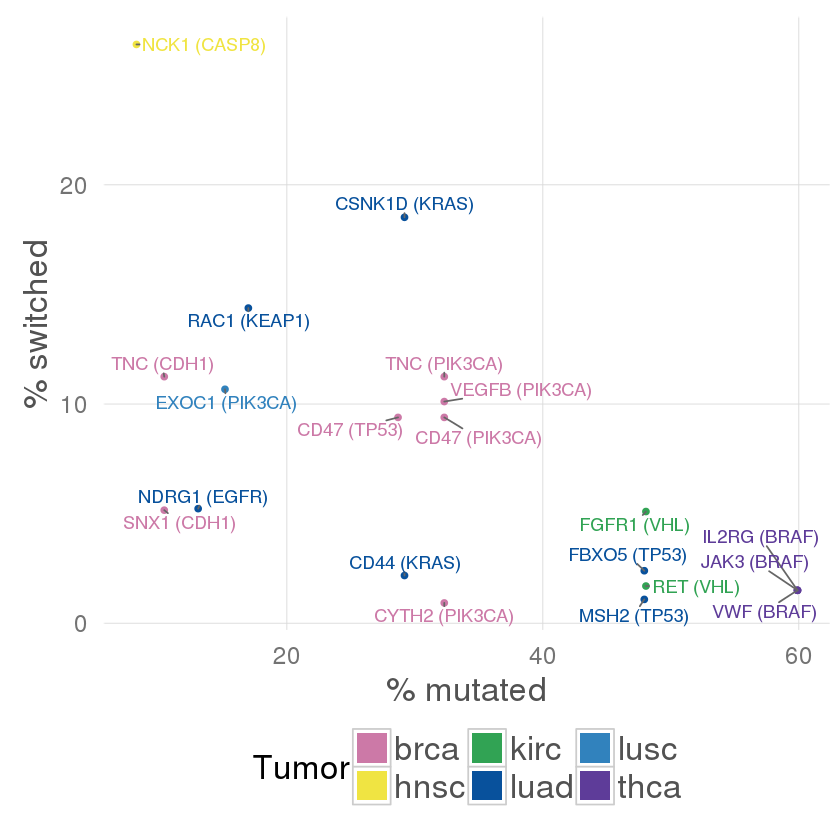

In [3]:
potus.d <- merge(subset(me.specificDrivers, p.me < 0.05 & Distance>0 & Pathway!=""),
                 candidates,by=c("Tumor","GeneId","Symbol","Normal_transcript","Tumor_transcript"))

ggplot(potus.d,aes(x=(MS.p+M.p)*100,y=(MS.p+S.p)*100,color=Tumor)) + 
    geom_point() +
    geom_text_repel(aes(label=paste0(Symbol," (",DriverSymbol,")"))) +
    labs(x="% mutated", y="% switched") +
    scale_color_manual(values=colorPalette) +
    smartas_theme() +
    theme(legend.position="bottom") +
    guides(col = guide_legend(override.aes = list(shape = 15, size = 8)))

## Summary

In [4]:
pn <- as.data.frame(table(unique(potus.pn[,c("Tumor","GeneId","Normal_transcript","Tumor_transcript")])$Tumor))
colnames(pn) <- c("Tumor","Pan-negative")
d <- as.data.frame(table(unique(potus.d[,c("Tumor","GeneId","Normal_transcript","Tumor_transcript")])$Tumor))
colnames(d) <- c("Tumor","Driver")

df <- merge(pn,d,all=T)
df

,Tumor,Pan-negative,Driver
1,brca,28,5
2,coad,17,0
3,hnsc,15,1
4,kich,0,NA
5,kirc,76,2
6,kirp,0,NA
7,lihc,6,0
8,luad,96,6
9,lusc,11,1
10,prad,14,0


In [5]:
potus <- unique(rbind(
  potus.d[,c("Tumor","GeneId","Symbol","Normal_transcript","Tumor_transcript")],
  potus.pn[,c("Tumor","GeneId","Symbol","Normal_transcript","Tumor_transcript")]))

nrow(unique(potus[,c("GeneId","Symbol","Normal_transcript","Tumor_transcript")]))

[1] 272

# Tumor affectation

In [6]:
alterations <- list()
for (cancer in cancerTypes){
  
  # correct tag according to Intogen nomenclature
  if (cancer=="coad"){
    tag="COREAD"
  } else if  (cancer=="kich") {
    next
  } else if (cancer=="kirp") {
    next
  } else if (cancer=="kirc") {
    tag <- "RCCC"
  } else if (cancer=="lihc") {
    tag <- "HC"
  } else {
    tag <- toupper(cancer)
  }
  
  # read switches
  this.switches <- subset(switches, Tumor==cancer)
  this.switches <- merge(this.switches,potus)
  
  ## count number of AS drivers switched per patient
  switchesPerPatient <- table(unlist(strsplit(as.character(this.switches$Patients_affected),",")))
  
  # get sample names
  psi.nt.file <- paste0("/projects_rg/TCGA/pipeline/run11/",cancer,"_iso_psi_paired-filtered.txt")
  psi.t.file <- paste0("/projects_rg/TCGA/pipeline/run11/",cancer,"_iso_psi_tumor-filtered.txt")
  
  patients.nt <- readLines(psi.nt.file, n=1)
  patients.nt <- unlist(strsplit(patients.nt,"\t"))
  patients.t <- readLines(psi.t.file, n=1)
  patients.t <- unlist(strsplit(patients.t,"\t"))
  
  patients <- c(patients.nt,patients.t)
  tumor <- grep("^.{4}T$",patients, value=TRUE)
  
  # read mutations  
  ## get cancer specific drivers
  this.drivers <- drivers[drivers$Tumor_type==tag,]
  
  ## read mutations
  mutations.file <- paste0("~/smartas/data/ucsc/rawdata/",cancer,"_gene_mutation-functional-count_full.txt")
  mutations <- read.delim(mutations.file,header=F)
  colnames(mutations) <- c("chr","start","end","gene","wut1","wut2","wut3","wut4","wut5","alteration","wut6","wut7")
  mutations <- mutations[mutations$alteration!=".",]
  mutations$Symbol <- unlist(strsplit(as.character(mutations$gene),"|",fixed=T))[c(T,F)]
  mutations$Patient <- unlist(strsplit(as.character(mutations$alteration),";"))[c(T,F)]
  
  ## filter out mutations not in drivers
  mutations.drivers <- mutations[mutations$Symbol %in% this.drivers$geneHGNCsymbol,]
  
  ## consider only mutated genes, not several mutations in a gene
  mutations.drivers <- unique(mutations.drivers[,c("gene","Patient")])
  
  ## count number of mutations per patient
  mutationsPerPatient <- table(mutations.drivers$Patient)
  
  # get patients common between paired patients screened for switches, 
  # patients screened for mutations
  patients.mut <- unique(mutations$Patient)
  patients.common <- intersect(tumor,patients.mut)
  
  ## filter out those patients without full information
  switchesPerPatient <- switchesPerPatient[patients.common]
  names(switchesPerPatient) <- patients.common
  switchesPerPatient[is.na(switchesPerPatient)] <- 0
  switchesPerPatient <- switchesPerPatient/nrow(this.switches)
  
  mutationsPerPatient <- mutationsPerPatient[patients.common]
  names(mutationsPerPatient) <- patients.common
  mutationsPerPatient[is.na(mutationsPerPatient)] <- 0
  mutationsPerPatient <- mutationsPerPatient/nrow(this.drivers)
  
  # merge lists
  alterationsPerPatient <- as.data.frame(t(rbind.fill.matrix(t(switchesPerPatient), t(mutationsPerPatient))))
  colnames(alterationsPerPatient) <- c("Switches","Mutations")
  alterationsPerPatient$Tumor <- cancer
  
  alterations[[cancer]] <- alterationsPerPatient
  
}

alterationsPerPatient <- do.call("rbind",alterations)
alterationsPerPatient$Switches[is.na(alterationsPerPatient$Switches)] <- 0
alterationsPerPatient$Mutations[is.na(alterationsPerPatient$Mutations)] <- 0

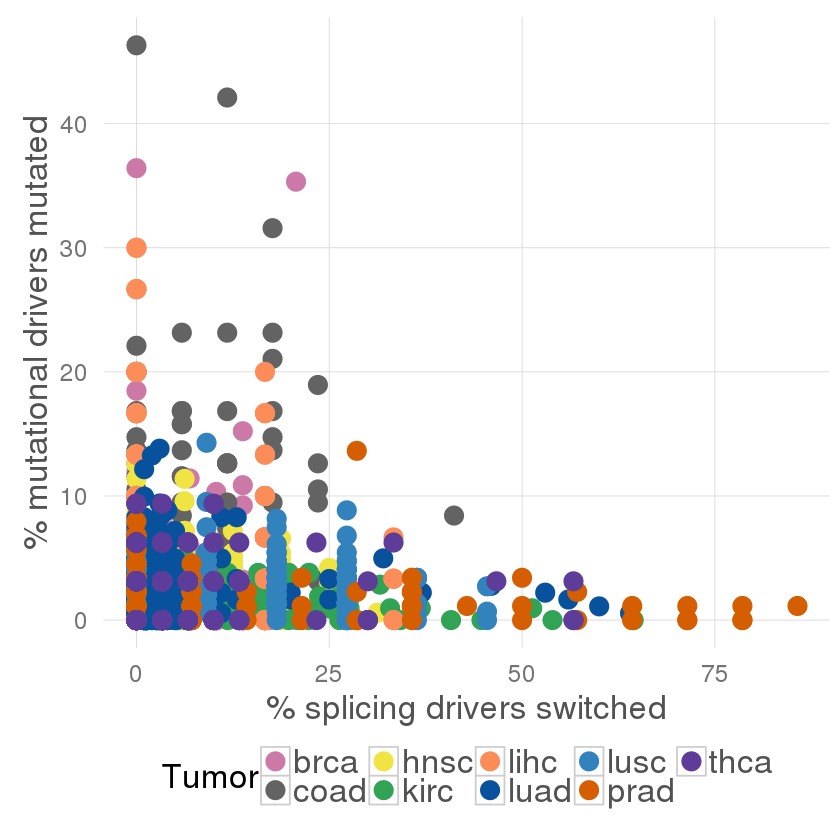

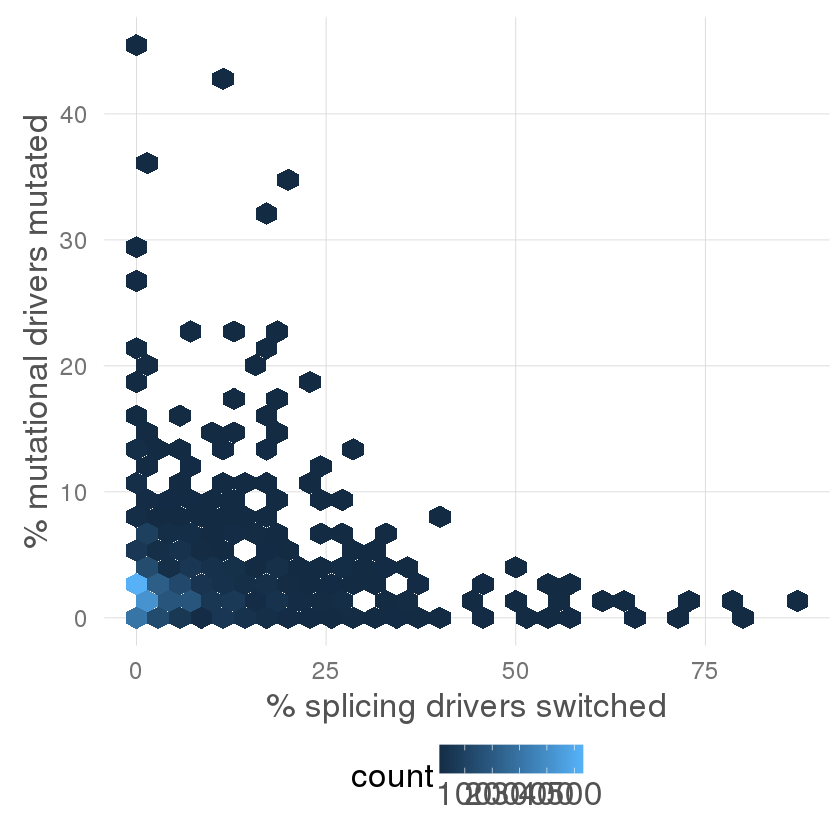

In [7]:
library(hexbin)
library(RColorBrewer)

# plot raw frequency
ggplot(alterationsPerPatient,aes(x=Switches*100,y=Mutations*100,color=Tumor)) + 
  geom_point(size=5) + 
  smartas_theme() +
  labs(x="% splicing drivers switched",y="% mutational drivers mutated") +
  scale_color_manual(values=colorPalette) +
  theme(legend.position="bottom")

# plot 2d density
rf <- colorRampPalette(rev(brewer.pal(11,'Spectral')))
ggplot(alterationsPerPatient,aes(x=Switches*100,y=Mutations*100)) + 
  stat_binhex() +
  smartas_theme() +
  labs(x="% splicing drivers switched",y="% mutational drivers mutated") +
  theme(legend.position="bottom")

Warning message:
: Stacking not well defined when ymin != 0

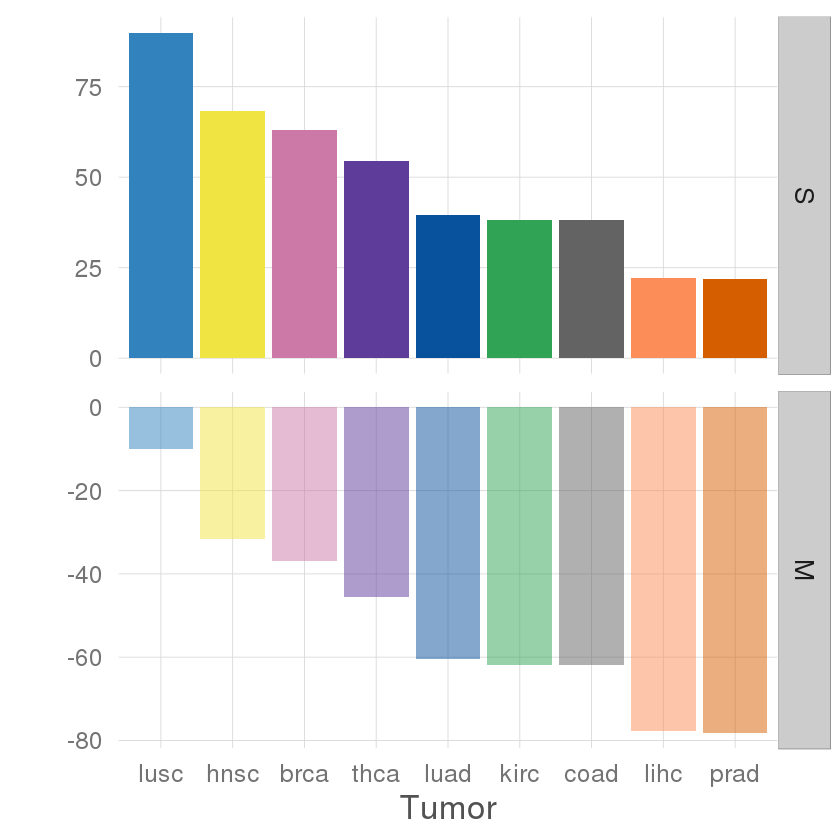

In [8]:
alterationsPerPatient$Class <- "M"
alterationsPerPatient$Class[alterationsPerPatient$Mutations < alterationsPerPatient$Switches] <- "S"

df <- as.data.frame(table(alterationsPerPatient$Class,alterationsPerPatient$Tumor))
colnames(df) <- c("Class","Tumor","Counts")

total <- as.data.frame(table(alterationsPerPatient$Tumor))
colnames(total) <- c("Tumor","Patients")

df <- merge(df,total)
df$Prop <- df$Counts/df$Patients


df$Tumor <- factor(df$Tumor, levels=df$Tumor[df$Class=="M"][order(df$Prop[df$Class=="M"])])
df$Class <- factor(df$Class, levels=c("S","M"))

ggplot() + 
    geom_bar(data=subset(df, Class=="M"),aes(x=Tumor,y=-Prop*100,fill=Tumor),stat="identity",alpha=0.5) +
    geom_bar(data=subset(df, Class=="S"),aes(x=Tumor,y=Prop*100,fill=Tumor),stat="identity") +
    scale_fill_manual(values=colorPalette) +
    labs(y="") +
    facet_grid(Class~.,scale="free_y") +
    smartas_theme()